# 🎴 Proyecto de Visión Artificial: Detección y Segmentación de Cartas
**Asignatura:** Visión por Computador | **Periodo:** 67 | **Estudiante:** Marco Cajamarca C. (@marcoxskii)

## Introducción
El objetivo de este proyecto es desarrollar y desplegar un sistema de visión artificial capaz de detectar, clasificar y segmentar naipes en tiempo real. Para ello, se utiliza el estado del arte en redes neuronales convolucionales (CNN), específicamente la arquitectura **YOLO (You Only Look Once)**.

El flujo de trabajo se divide en tres etapas críticas:
1.  **Preparación del Entorno:** Configuración de librerías y validación de aceleración por hardware (GPU).
2.  **Entrenamiento:** Fine-tuning de un modelo pre-entrenado utilizando un dataset personalizado.
3.  **Despliegue (Inferencia):** Implementación de una interfaz web interactiva para pruebas en tiempo real.

## Stack Tecnológico y Hardware
Para asegurar un rendimiento óptimo en inferencia y entrenamiento, se utiliza la siguiente infraestructura:

* **Motor de IA:** PyTorch con soporte CUDA.
* **Modelo:** Ultralytics YOLOv8/v11 (Segmentación).
* **Hardware de Procesamiento:** NVIDIA GeForce RTX 3070 (Lab 8).
* **Interfaz de Usuario:** Streamlit (Web Dashboard).

## Comandos
Entorno:

```bash
# activar el entorno
source venv/bin/activate

# Desactivar el entorno
deactivate
```

Streamlit:
```bash
# Ejecutar la aplicación web visible desde tu Mac
# (La bandera 0.0.0.0 es necesaria para que funcione por Tailscale)
streamlit run app.py --server.address 0.0.0.0
```


## 1. Imports y Configs
En esta etapa se cargan las librerías fundamentales para el ciclo de vida del proyecto:

* **Core de IA:** `torch` (PyTorch) y `ultralytics` para la gestión de tensores y la arquitectura YOLO.
* **Visión por Computador:** `cv2` (OpenCV) y `PIL` para el preprocesamiento de imágenes y gestión de video.
* **Interfaz:** `ipywidgets` para controles interactivos dentro del cuaderno.

Además, se definen **constantes globales** (`PROJECT_NAME`, `RUN_NAME`) para estandarizar la estructura de directorios y garantizar que los resultados del entrenamiento (pesos, logs) se guarden de forma ordenada y reproducible.

In [1]:
# ---------------------------------------------------------
import torch
import platform
import socket
import uuid
import os
import cv2
import time
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
from datetime import datetime
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image

# --- variables de config ---
PROJECT_NAME = 'Proyecto_Cartas'       # carpeta raíz de los experimentos
RUN_NAME = 'entrenamiento_v3_robusto'       # nombre específico de esta iteración
DATA_YAML = 'datasets/cartas/data.yaml' # ruta al archivo de configuración del dataset

# ruta dinamica donde se guardará el mejor modelo tras el entrenamiento
BEST_MODEL_PATH = os.path.join('runs', 'segment', RUN_NAME, 'weights', 'best.pt')

# creación automatica de carpetas si no existen
os.makedirs(PROJECT_NAME, exist_ok=True)

print(f"-> entorno configurado correctamente!")
print(f"nombre del proyecto: {PROJECT_NAME}")
print(f"meta de Run: {RUN_NAME}")
# ---------------------------------------------------------

-> entorno configurado correctamente!
nombre del proyecto: Proyecto_Cartas
meta de Run: entrenamiento_v3_robusto


## 2. Auditoría del Sistema y Hardware
Antes de iniciar el proceso de entrenamiento, es imperativo validar la disponibilidad de recursos de aceleración por hardware (GPU).

En esta celda se verifica:
* **Entorno de Software:** Versiones de Python y PyTorch para asegurar compatibilidad.
* **Aceleración CUDA:** Confirmación de que PyTorch tiene acceso directo a la tarjeta gráfica NVIDIA.
* **Capacidad de VRAM:** Verificación de memoria disponible para determinar el tamaño del *batch* (lote) permitido durante el entrenamiento.

In [2]:
print(f"auditoria del sistema: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 60)

# Definimos el ancho de la columna para alinear todo perfecto
col = 24 

# 1. Información del Host y SO
print(f"{'hostname:':<{col}} {socket.gethostname()}")
print(f"{'sistema OS:':<{col}} {platform.system()} {platform.release()}")
print(f"{'version de Python:':<{col}} {platform.python_version()}")

# 2. Información de PyTorch y CUDA
print(f"{'version de PyTorch:':<{col}} {torch.__version__}")

# Verificación de GPU
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(current_device)
    
    # Obtener propiedades de memoria para mostrar VRAM
    props = torch.cuda.get_device_properties(current_device)
    total_memory = props.total_memory / (1024**3) # Convertir a GB
    
    print(f"\n estado del gpu:")
    # Restamos 3 al ancho porque hay 3 espacios de sangría al inicio
    print(f"   {'tarjeta grafica:':<{col-3}} {gpu_name}")
    print(f"   {'computo CUDA:':<{col-3}} v{torch.version.cuda}")
    print(f"   {'vram total:':<{col-3}} {total_memory:.2f} GB")
    print(f"   {'dispositivos:':<{col-3}} {device_count} unidad(es)")
else:
    print("\n ! estado: modo CPU")
    print("   No se detectó GPU compatible con CUDA.")

print("-" * 60)

auditoria del sistema: 2026-01-08 17:03:58
------------------------------------------------------------
hostname:                cisco-optiplex7000
sistema OS:              Linux 6.14.0-37-generic
version de Python:       3.12.3
version de PyTorch:      2.6.0+cu124

 estado del gpu:
   tarjeta grafica:      NVIDIA GeForce RTX 3070
   computo CUDA:         v12.4
   vram total:           7.78 GB
   dispositivos:         1 unidad(es)
------------------------------------------------------------


## 3. Configuración del Dataset
El modelo se entrenará utilizando un dataset estructurado bajo el formato estándar de YOLO. La configuración del mismo se define en el archivo `data.yaml`, el cual contiene:

* **Rutas:** Ubicación de los conjuntos de entrenamiento (train) y validación (val).
* **Clases:** Definición de los objetos a segmentar.

A continuación, se valida la integridad del archivo de configuración antes de iniciar el proceso de aprendizaje.

In [3]:
import yaml

print(f"verificacion del dataset: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 60)

# Definimos ancho de columna para alineación
col = 24

# Verificar si el archivo existe
if os.path.exists(DATA_YAML):
    print(f"{'estado de archivo:':<{col}} encontrado con exito.")
    print(f"{'ruta del config:':<{col}} {DATA_YAML}")
    
    # Leer el contenido del YAML para mostrarlo
    with open(DATA_YAML, 'r') as stream:
        try:
            data_info = yaml.safe_load(stream)
            
            # Extraer info clave
            num_classes = data_info.get('nc', 'N/A')
            class_names = data_info.get('names', [])
            
            print(f"{'numero de clases:':<{col}} {num_classes}")
            print(f"\n clases definidas:")
            
            # Listar clases de forma ordenada
            # Si es un diccionario (formato antiguo) o lista (formato nuevo)
            if isinstance(class_names, list):
                for i, name in enumerate(class_names):
                    print(f"   [{i}] {name}")
            elif isinstance(class_names, dict):
                for k, v in class_names.items():
                    print(f"   [{k}] {v}")
                    
        except yaml.YAMLError as exc:
            print(f"\n ! error leyendo yaml: {exc}")
else:
    print(f"{'estado de archivo:':<{col}} no encontrado ❌")
    print(f"\n ! advertencia:")
    print(f"   ! no se encontro el archivo en: {DATA_YAML}")
    print(f"   ! asegurate de subir la carpeta 'datasets' o ajustar la ruta.")

print("-" * 60)

verificacion del dataset: 2026-01-08 17:03:58
------------------------------------------------------------
estado de archivo:       encontrado con exito.
ruta del config:         datasets/cartas/data.yaml
numero de clases:        N/A

 clases definidas:
   [0] Playing Card
------------------------------------------------------------


## 4. Entrenamiento del Modelo (Fine-Tuning)
En esta fase se ejecuta el ciclo de entrenamiento supervisado. Se utiliza la técnica de **Transfer Learning**, partiendo de los pesos pre-entrenados `yolov8n-seg.pt` (versión Nano para segmentación) para acelerar la convergencia.

**Hiperparámetros definidos:**
* **Épocas:** 50 (Iteraciones completas sobre el dataset).
* **Batch Size:** 16 (Optimizado para 8GB de VRAM).
* **Tamaño de Imagen:** 640px.
* **Dispositivo:** GPU 0 (NVIDIA RTX 3070).

El proceso generará artefactos de salida (pesos, gráficas de pérdida, métricas) en el directorio `runs/segment/entrenamiento_v1`.

In [4]:
print(f"inicio de entrenamiento: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 60)

# Configuración de hiperparámetros
EPOCHS = 60        # (50-100 es bueno)
IMG_SIZE = 640
BATCH_SIZE = 8    # 16 va sobrado en la 3070. Podrías subir a 32 si quieres ir más rápido.
MODEL_TYPE = 'yolov8m-seg.pt' # Modelo base (medium segmentation)

print(f"{'modelo base:':<24} {MODEL_TYPE}")
print(f"{'epocas:':<24} {EPOCHS}")
print(f"{'batch size:':<24} {BATCH_SIZE}")
print(f"{'dispositivo:':<24} GPU (cuda:0)")

print("\n -> iniciando proceso de entrenamiento...")
print("-" * 60)

# Iniciar cronómetro
start_time = time.time()

# 1. Cargar el modelo base
model = YOLO(MODEL_TYPE)

# 2. Ejecutar entrenamiento
# project y name definen dónde se guarda: runs/segment/entrenamiento_v1
results = model.train(
    data=DATA_YAML,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=0,
    project=PROJECT_NAME,
    name=RUN_NAME,
    exist_ok=True, 
    patience=20,
    verbose=True,

    hsv_h=0.015,  # Cambia ligeramente el tono (Hue)
    hsv_s=0.7,    # Cambia mucho la saturación (para que aprenda cartas pálidas o muy vivas)
    hsv_v=0.4,    # Cambia el brillo (Valor). CRUCIAL para detectar en oscuro/claro.
    degrees=10,   # Rota las cartas +/- 10 grados
    scale=0.5,    # Hace las cartas más grandes o más pequeñas (ayuda con tu problema de escala)
    mosaic=1.0,   # (IMPORTANTE) Mezcla 4 imágenes en 1. Obliga a ver la carta en contextos raros.
    fliplr=0.5,   # Voltea horizontalmente
    erasing=0.4,  # Borra pedacitos de la carta aleatoriamente (ayuda a que no necesite verla entera)
)

# Cálculo de duración
end_time = time.time()
duration = end_time - start_time
minutes = int(duration // 60)
seconds = int(duration % 60)

print("-" * 60)
print(f"-> entrenamiento finalizado exitosamente.")
print(f"tiempo total: {minutes} min {seconds} seg")
print(f"pesos guardados en: {os.path.join(PROJECT_NAME, RUN_NAME, 'weights')}")
print("-" * 60)

inicio de entrenamiento: 2026-01-08 17:03:58
------------------------------------------------------------
modelo base:             yolov8m-seg.pt
epocas:                  60
batch size:              8
dispositivo:             GPU (cuda:0)

 -> iniciando proceso de entrenamiento...
------------------------------------------------------------
New https://pypi.org/project/ultralytics/8.3.250 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.249 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3070, 7967MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/cartas/data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2182.7±1604.9 MB/s, size: 19.5 KB)
train: Scanning /home/mkt/data/projects/ProyectoYOLO/Fase_1A_Segmentacion/datasets/cartas/train/labels... 519 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 519/519 1.1Kit/s 0.5s<0.1s
train: New cache created: /home/mkt/data/projects/ProyectoYOLO/Fase_1A_Segmentacion/datasets/cartas/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 885.1±567.6 MB/s, size: 20.7 KB)
val: Scanning /home/mkt/data/projects/ProyectoYOLO/Fase_1A_Segmentacion/datasets/cartas/valid/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 30/30 31.6Kit/s 0.0s
Plotting labels to /home/mkt/data/projects/ProyectoYOLO/Fase_1A_Segmentacion/Proyecto_Cartas/entrenamiento_v3_robusto/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, moment

## 5. Análisis de Métricas y Resultados
Tras completar el ciclo de entrenamiento, se procede a evaluar el desempeño del modelo mediante las métricas generadas automáticamente por YOLO.

Se analizan dos tipos de gráficos críticos:
1.  **Curvas de Pérdida (Loss):** Indican qué tan rápido el modelo reduce su error tanto en la localización de la caja (`box_loss`) como en la máscara de segmentación (`seg_loss`).
2.  **Métricas de Precisión:**
    * **Precision & Recall:** Capacidad de acertar positivos verdaderos versus falsos positivos.
    * **mAP50-95:** (Mean Average Precision) El estándar de oro para medir la calidad de detección en distintos umbrales de intersección.

Adicionalmente, se busca la **Matriz de Confusión** para visualizar posibles errores de clasificación entre el fondo y el objeto de interés.

analisis de entrenamiento: 2026-01-08 17:17:17
------------------------------------------------------------
estado de gráficas:      encontradas ✅
directorio:              Proyecto_Cartas/entrenamiento_v3_robusto


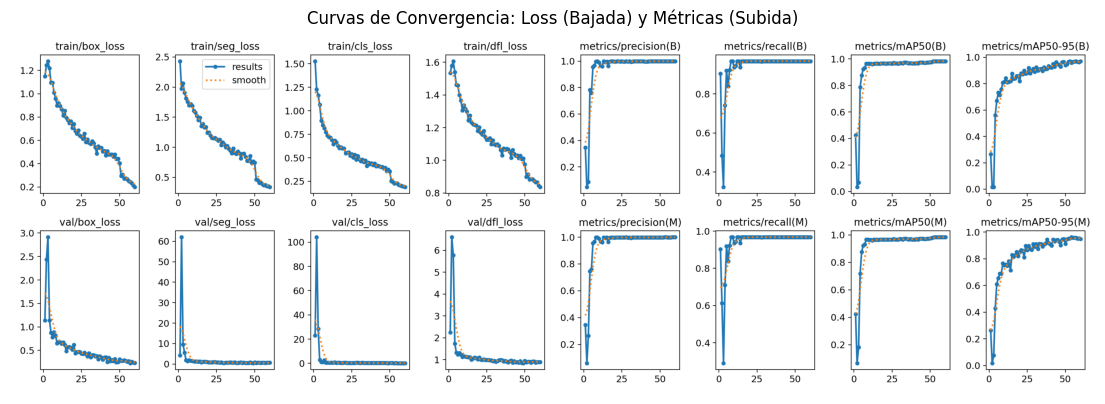

matriz de confusión:     disponible


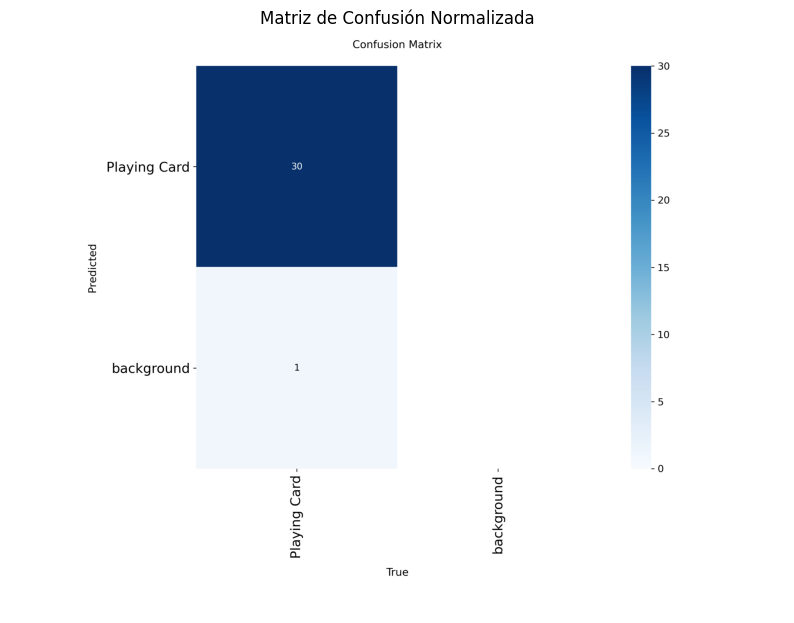

------------------------------------------------------------


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# RUTA DE RESULTADOS
results_dir = os.path.join(PROJECT_NAME, RUN_NAME)
results_png = os.path.join(results_dir, 'results.png')
confusion_matrix = os.path.join(results_dir, 'confusion_matrix.png')

print(f"analisis de entrenamiento: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 60)

col = 24 # Ancho de columna para alineación

# 1. Verificar si existen los archivos
if os.path.exists(results_png):
    print(f"{'estado de gráficas:':<{col}} encontradas ✅")
    print(f"{'directorio:':<{col}} {results_dir}")
    
    # Mostrar resultados (Curvas de Loss y Precision)
    plt.figure(figsize=(14, 8))
    img_res = Image.open(results_png)
    plt.imshow(img_res)
    plt.axis('off')
    plt.title("Curvas de Convergencia: Loss (Bajada) y Métricas (Subida)")
    plt.show()
    
    # Mostrar Matriz de Confusión (Si existe)
    if os.path.exists(confusion_matrix):
        print(f"{'matriz de confusión:':<{col}} disponible")
        plt.figure(figsize=(10, 8))
        img_cm = Image.open(confusion_matrix)
        plt.imshow(img_cm)
        plt.axis('off')
        plt.title("Matriz de Confusión Normalizada")
        plt.show()
    else:
        print(f"{'matriz de confusión:':<{col}} no generada ⚠️")
        print(f"{'motivo posible:':<{col}} pocas épocas o dataset sin val")

else:
    print(f"{'estado de gráficas:':<{col}} no encontradas ❌")
    print(f"   Verifica que el entrenamiento terminó correctamente.")

print("-" * 60)

## 6. Validación Visual (Inferencia en Lote)
Más allá de las métricas numéricas, es fundamental realizar una inspección cualitativa. En esta fase, se carga el **mejor modelo** guardado (`best.pt`) y se ejecuta una inferencia sobre el conjunto de validación (`val`).

El objetivo es visualizar cómo el modelo aplica las máscaras de segmentación sobre imágenes que nunca vio durante el entrenamiento, permitiendo identificar problemas como sobreajuste (overfitting) o falsos positivos en el fondo.

validacion visual: 2026-01-08 17:17:18
------------------------------------------------------------
modelo seleccionado:     best.pt
ruta de pesos:           Proyecto_Cartas/entrenamiento_v3_robusto/weights/best.pt

 ejecutando validación en batch...
Ultralytics 8.3.249 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3070, 7967MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,222,963 parameters, 0 gradients, 104.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2845.8±564.4 MB/s, size: 25.2 KB)
val: Scanning /home/mkt/data/projects/ProyectoYOLO/Fase_1A_Segmentacion/datasets/cartas/valid/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 30/30 123.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 3.4it/s 0.6s1.0s
                   all         30         31      0.998      0.968      0.983      0.971      0.998      0.968      0.9

visualizando:            val_batch0_pred.jpg


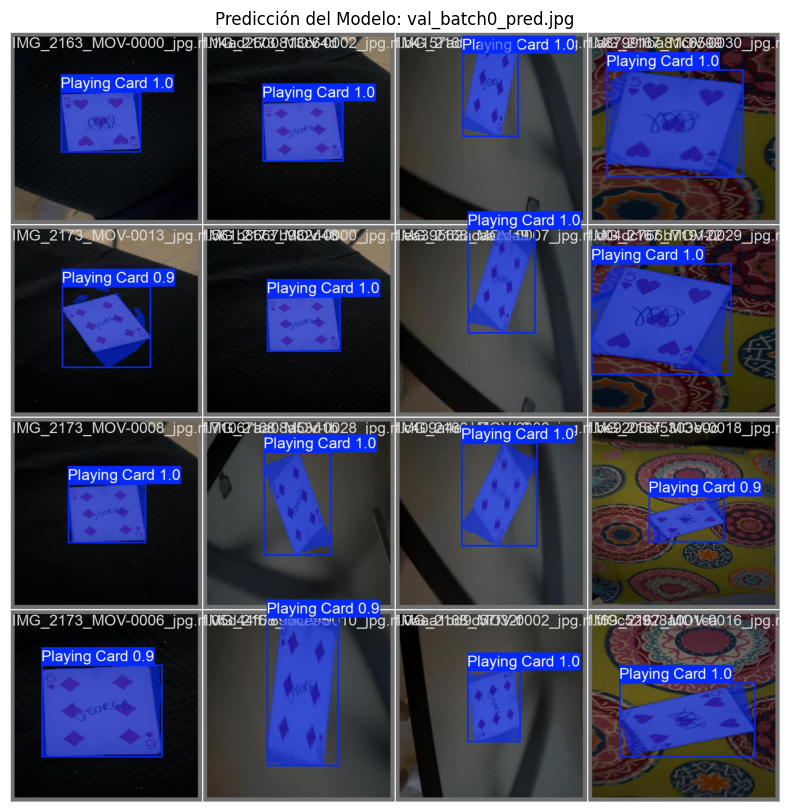

------------------------------------------------------------


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
print(f"validacion visual: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 60)

col = 24

# Cargar el MEJOR modelo obtenido del entrenamiento
best_model_path = os.path.join(PROJECT_NAME, RUN_NAME, 'weights', 'best.pt')

if os.path.exists(best_model_path):
    print(f"{'modelo seleccionado:':<{col}} best.pt")
    print(f"{'ruta de pesos:':<{col}} {best_model_path}")
    
    # Cargar modelo en memoria
    best_model = YOLO(best_model_path)
    
    print(f"\n ejecutando validación en batch...")
    # Ejecutar validación y guardar un batch de predicciones
    # Esto genera archivos 'val_batchX_pred.jpg'
    metrics = best_model.val(data=DATA_YAML, split='val', plots=True, device=0, verbose=False)
    
    # Buscar las imágenes de predicción generadas por YOLO
    # YOLOv8 suele guardar esto en la misma carpeta del run
    pred_images = [
        os.path.join(PROJECT_NAME, RUN_NAME, 'val_batch0_pred.jpg'),
        os.path.join(PROJECT_NAME, RUN_NAME, 'val_batch1_pred.jpg'),
        os.path.join(PROJECT_NAME, RUN_NAME, 'val_batch2_pred.jpg')
    ]
    
    found_any = False
    for img_path in pred_images:
        if os.path.exists(img_path):
            found_any = True
            print(f"{'visualizando:':<{col}} {os.path.basename(img_path)}")
            
            plt.figure(figsize=(16, 10))
            img_val = Image.open(img_path)
            plt.imshow(img_val)
            plt.axis('off')
            plt.title(f"Predicción del Modelo: {os.path.basename(img_path)}")
            plt.show()
            
            # Mostramos solo el primer batch para no saturar el notebook
            break 
            
    if not found_any:
        print(f"{'resultado visual:':<{col}} no generado automáticamente")
        print("   Probando inferencia manual en una imagen de muestra...")
        # Aquí podrías poner código fallback si quisieras
else:
    print(f"{'error crítico:':<{col}} modelo no encontrado ❌")
    print(f"   No existe: {best_model_path}")

print("-" * 60)

## 7. Despliegue e Interfaz de Usuario (Dashboard)
Para finalizar el ciclo de desarrollo, se ha implementado una interfaz gráfica interactiva basada en **Streamlit**. Esta herramienta permite:

* **Inferencia en Tiempo Real:** Utilizando la webcam o archivos de video.
* **Ajuste de Parámetros:** Modificación dinámica del umbral de confianza (Confidence Threshold).
* **Auditoría de Hardware:** Visualización en vivo del consumo de recursos.

A continuación, se despliega el panel de control directamente en el entorno del notebook.

In [7]:
from IPython.display import IFrame

print(f"despliegue de interfaz: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 60)

# URL de tu servidor Streamlit (IP de Tailscale)
DASHBOARD_URL = "http://100.76.3.19:8501"

print(f"conectando al dashboard en: {DASHBOARD_URL}")
print("estado: activo 🟢")

# Renderizar la web dentro del notebook
IFrame(src=DASHBOARD_URL, width="100%", height=850)

# streamlit run app.py

despliegue de interfaz: 2026-01-08 17:17:20
------------------------------------------------------------
conectando al dashboard en: http://100.76.3.19:8501
estado: activo 🟢
